In [9]:
%cd ..
%ls

/Users/matusbojko/Desktop/dp-project/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/matusbojko/Desktop/dp-project
LICENSE           main.ipynb        project/
README.md         notebooks/        requirements.txt
data/             prepare.sh*       run/


In [10]:
from project.datamodule import BaseDataSets, RandomGenerator,TwoStreamBatchSampler,patients_to_slices
from project.utils import worker_init_fn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import colors
from torchvision import transforms
from scipy.ndimage import zoom
from medpy import metric
import torch
import random
import numpy as np

In [1]:

def show_sample(image,label):

    # Convert PyTorch tensor (image) to NumPy array and squeeze the channel dimension if necessary
    if isinstance(image, np.ndarray):
        image_np = image  # Already a NumPy array
    else:
        image_np = image.numpy()  # Convert PyTorch tensor to NumPy array
    
    # Squeeze the singleton channel dimension (1, 254, 254) -> (254, 254)
    if image_np.shape[0] == 1:
        image_np = np.squeeze(image_np, axis=0)  # Remove the channel dimension

    # Define a color map for the labels: 0 (background), 1, 2, 3
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue'])  # Customize these colors as needed
    bounds = [0, 1, 2, 3, 4]  # Boundaries for the label values
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10, 5))

    # Plot the image (assuming it's grayscale)
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, cmap='gray')  # Display image as grayscale
    plt.title('Image')

    # Plot the label with the custom color map
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap=cmap, norm=norm)  # Color the label based on defined cmap
    plt.colorbar(ticks=[0, 1, 2, 3])  # Show the color bar with label values
    plt.title('Colored Segmentation Mask')

    plt.show()

Package           Version
----------------- -----------
appnope           0.1.4
asttokens         2.4.1
comm              0.2.2
debugpy           1.8.7
decorator         5.1.1
executing         2.1.0
ipykernel         6.29.5
ipython           8.28.0
jedi              0.19.1
jupyter_client    8.6.3
jupyter_core      5.7.2
matplotlib-inline 0.1.7
nest-asyncio      1.6.0
packaging         24.1
parso             0.8.4
pexpect           4.9.0
pip               24.2
platformdirs      4.3.6
prompt_toolkit    3.0.48
psutil            6.0.0
ptyprocess        0.7.0
pure_eval         0.2.3
Pygments          2.18.0
python-dateutil   2.9.0.post0
pyzmq             26.2.0
six               1.16.0
stack-data        0.6.3
tornado           6.4.1
traitlets         5.14.3
wcwidth           0.2.13
Note: you may need to restart the kernel to use updated packages.


In [21]:
random.seed(1337)
np.random.seed(1337)
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
torch.mps.manual_seed(1337)


db_train = BaseDataSets(base_dir="./data/ACDC", split="train", num=None, transform=transforms.Compose([
    RandomGenerator([256, 256])
]))

db_val = BaseDataSets(base_dir="./data/ACDC", split="val")

total_slices = len(db_train)
labeled_slice = patients_to_slices("ACDC", 7)
labeled_idxs = list(range(0, labeled_slice))
unlabeled_idxs = list(range(labeled_slice, total_slices))

batch_sampler = TwoStreamBatchSampler(labeled_idxs, unlabeled_idxs, 24, 24-12)

trainloader = DataLoader(db_train, batch_sampler=batch_sampler,num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valloader = DataLoader(db_val, batch_size=1, shuffle=False,num_workers=1)






| Labeled samples: 5.0%


In [17]:
def test_single_volume_ds(image, label):
    image, label = image.squeeze(0).cpu().detach().numpy(), label.squeeze(0).cpu().detach().numpy()
    #(1, 10, 256, 224) squeeze-> (10,256, 224) -> detach (gradient not longer computed for tensor)

    prediction = np.zeros_like(label)

    for ind in range(image.shape[0]): 
        slice = image[ind, :, :] # (256, 224)
        x, y = slice.shape[0], slice.shape[1] # 256, 224
        slice = zoom(slice, (256 / x, 256 / y), order=0) # 1, 1.14 -> after zoom (256,256)
        print(slice.shape)
        input = torch.from_numpy(slice).unsqueeze(0).unsqueeze(0).float().to("mps") # ADD CUDA or TO DEVICE -> ([1, 1, 256, 256])
        print(input.shape)
        
        net.eval()
        with torch.no_grad():
            output_main, _, _, _ = net(input)
            out = torch.argmax(torch.softmax(
                output_main, dim=1), dim=1).squeeze(0)
            out = out.cpu().detach().numpy()
            pred = zoom(out, (x / patch_size[0], y / patch_size[1]), order=0)
            prediction[ind] = pred
        metric_list = []
        for i in range(1, classes):
            metric_list.append(calculate_metric_percase(
                prediction == i, label == i))
        return metric_list

def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0:
        dice = metric.binary.dc(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        return dice, hd95
    else:
        return 0, 0

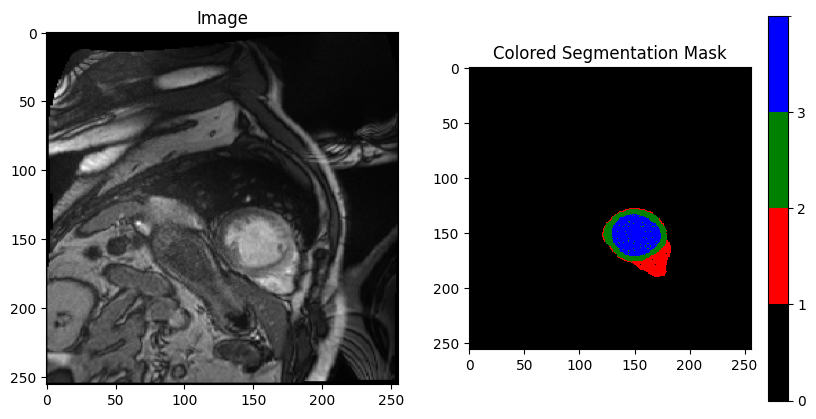

In [23]:
for i_batch, sampled_batch in enumerate(trainloader):
    volume_batch, label_batch = sampled_batch['image'], sampled_batch['label']

    # print(volume_batch.shape)
    # print(label_batch.shape)
    # print(i_batch)

    show_sample(volume_batch[0],label_batch[0])


    if i_batch == 0:
        break

#     torch.Size([24, 1, 256, 256])
# torch.Size([24, 256, 256])

In [1]:
import torch
print(torch.backends.cudnn.version())

None
